In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu118'

Machine learning is a game of two parts
1. Get data into a numberical representation.
2. Build a model to learn patterns in that numerical representation

In [ ]:
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets

In [ ]:
# Create a train split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

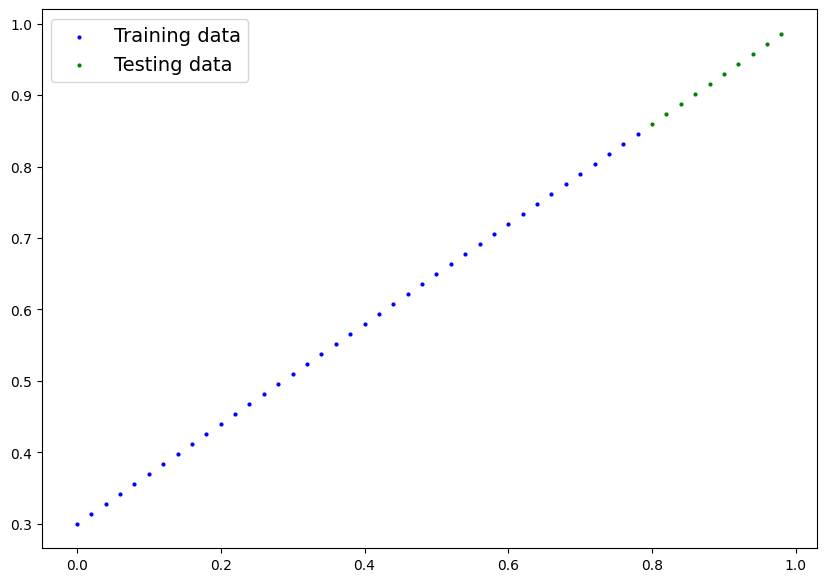

In [ ]:
plot_predictions()

## 2.Build model

what our models does
* Start with random values (weigh & bias)
* Look at training data and adjust the random values to better represent (or get close to) the ideal values(the weight % bias values we used to create the data)

How does it do so?
Through two main algorithms:
1. Gradient descent
2. backpropagation

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): #almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()

    #initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                             requires_grad=True,
                                             dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal bias
                                          requires_grad=True,
                                          dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formular

 ### PyTorch model building essentials

 * torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
 * torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
 * torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
 * torch.optim - this where the optimizes in PyTorch live, they will help with gradient descent
 * def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [ ]:
 # Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List name parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts y_test based on x_test

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# torch.no_grad() also works

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

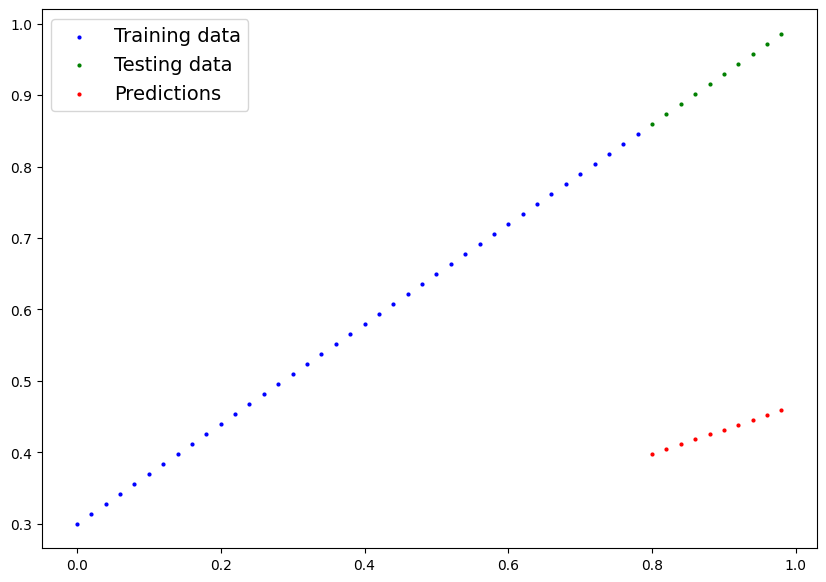

In [ ]:
plot_predictions(predictions=y_preds)

 ### 3. Train model
 the whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters

 Or in other words from a poor representation of the data to a better representations of the data.

 One way to measure how poor or how strong your models predictions are is to use a loss function

 * Note: Loss function may also be called cost function or criterion in different areas. For our case, we will use loss function

* **Loss function** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameter to imporve the loss function

And specifically for PyTorch, we need:
* A training loop
* A testing loop

Inside the optimizer you'll often have to set two parameters:
* params - the model parameters you'd like to optimize
* lr (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step.

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #lr = learning rate = possibly the most important hyperparameter you can set

 ### Building a training loop and a testing loop in PyTorch
 A couple of things we need in a training loop:
 0. Loop through the data
 1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
 2. Calculate the loss (compare forward pass predictions to ground truth labels)
 3. Optimizer zero grad
 4. Loss backward - move backwards through the network to calculate the gradients each of the parameters of our model with respect to the loss (**backpropagations**)
 5. Optimizer step - use the optimizer to adjust our model's parameters to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
# An epoch is one loop through the data
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop. So we have to zero them above in step 3 for the next iteration of the loop

  model_0.eval() # turns off gradient tracking
  with torch.inference_mode(): #turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
# Print out model state_dict()
print(f"Loss: {loss}")
print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

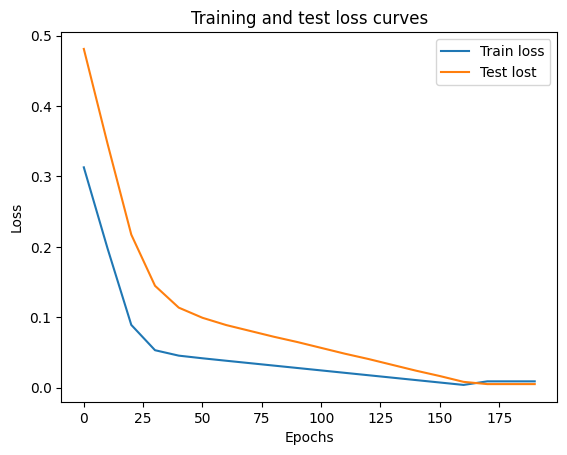

In [ ]:
# plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test lost")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
weight, bias

(0.7, 0.3)

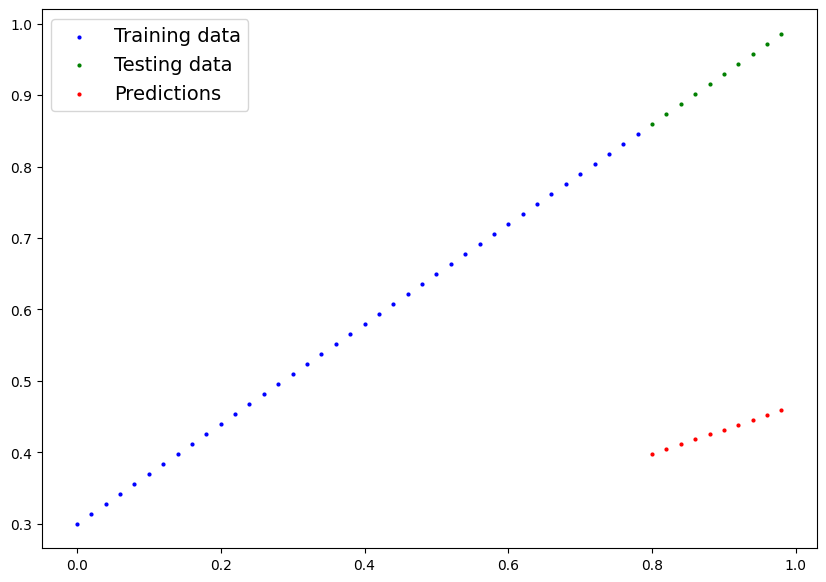

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds)

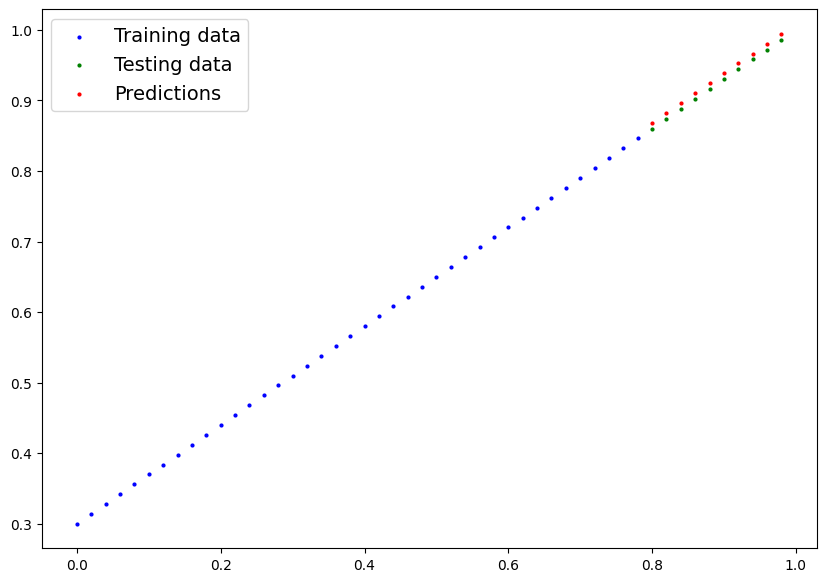

In [ ]:
plot_predictions(predictions=y_preds_new)

### Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Nov 26 00:40 01_pytorch_workflow_model_0.pth


### Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with original model preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together
Let's go back through the steps above and see it all in one place.

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.5
bias = 0.1

# Create range values
start = 0
end = 1
step = 0.02

# Create X and Y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.1000],
         [0.1100],
         [0.1200],
         [0.1300],
         [0.1400],
         [0.1500],
         [0.1600],
         [0.1700],
         [0.1800],
         [0.1900]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

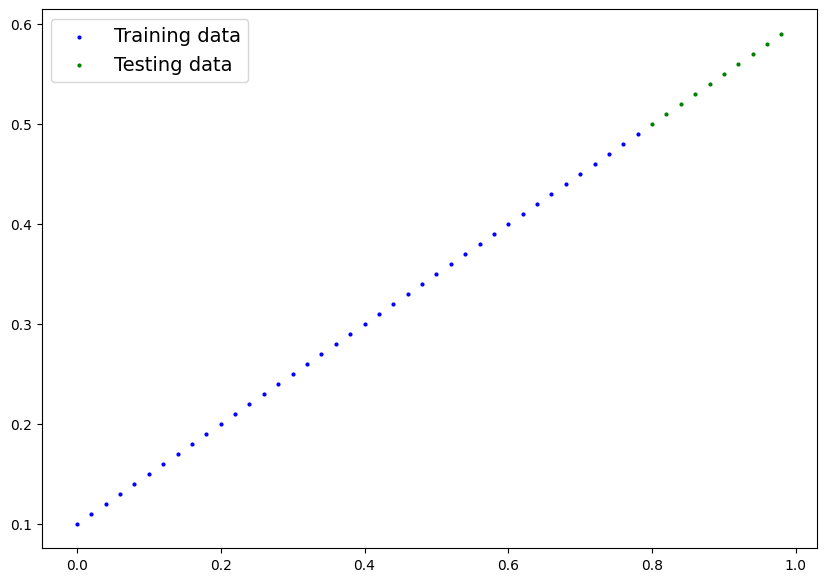

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a Pytorch Linear model


In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

For training we need:
* Loss function
* optimizer
* Training loop
* Testing loop

In [ ]:
# Setup loss Function
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001)

In [ ]:
# Write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)


    # Print out what's happening

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.0054933554492890835 | Test Loss: 0.0004534006293397397
Epoch: 10 | Loss: 0.0016911691054701805 | Test Loss: 0.003796640085056424
Epoch: 20 | Loss: 0.0013451336417347193 | Test Loss: 0.003038105322048068
Epoch: 30 | Loss: 0.0010021532652899623 | Test Loss: 0.002279561711475253
Epoch: 40 | Loss: 0.0006586491945199668 | Test Loss: 0.001452326774597168
Epoch: 50 | Loss: 0.0003147984098177403 | Test Loss: 0.0006937801954336464
Epoch: 60 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 70 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 80 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 90 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 100 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 110 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 120 | Loss: 0.0007540187216363847 | Test Loss: 0.0008550197235308588
Epoch: 130 | Loss: 0.000754

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4995]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.1010], device='cuda:0'))])

In [ ]:
weight, bias

(0.5, 0.1)

### 6.4 Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.5005],
        [0.5105],
        [0.5205],
        [0.5305],
        [0.5405],
        [0.5505],
        [0.5605],
        [0.5705],
        [0.5805],
        [0.5904]], device='cuda:0')

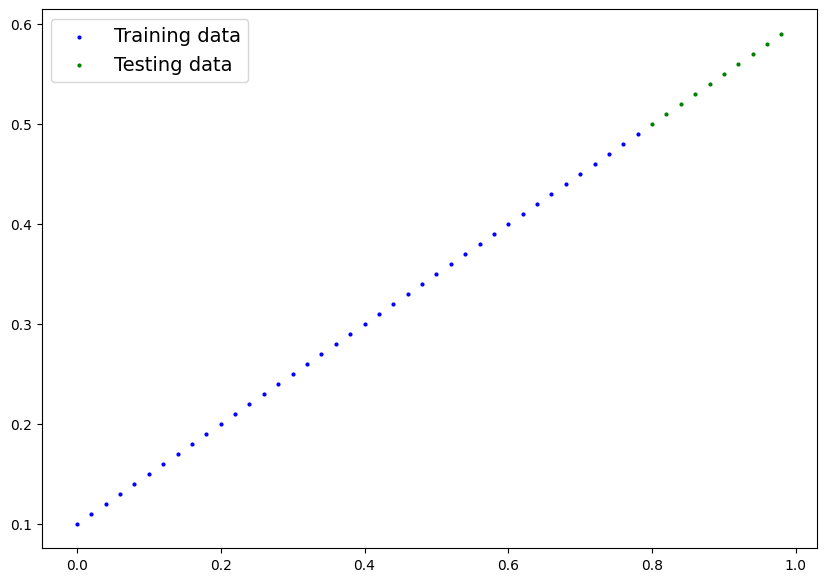

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

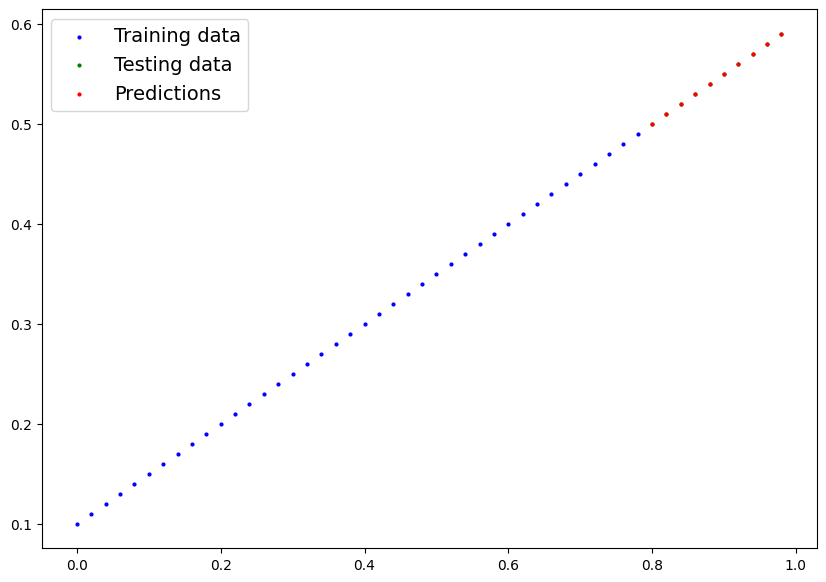

In [ ]:
# Check out our model predictions visually
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch

# Create a new instance of linear regression model V2
Loaded_model_1 = LinearRegressionModelV2()


# Load the saved model_1 state_dict
Loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


# Put the loaded model to device
Loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(Loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
Loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4995]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.1010], device='cuda:0'))])

In [ ]:
Loaded_model_1.to(device)
X_test = X_test.to(device)

In [ ]:
# Evaluate loaded model
Loaded_model_1.eval()

with torch.inference_mode():
  Loaded_model_1_preds = Loaded_model_1(X_test)

Loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')